In [22]:
import pickle
import radvel
import rebound as rb
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from scipy import optimize, stats
import corner
from radvel.plot import mcmc_plots
import reboundx
import emcee
from multiprocessing import Pool
import h5py
import time
from celmech.nbody_simulation_utilities import align_simulation
from tqdm import tqdm
from rebound.interruptible_pool import InterruptiblePool
import os

In [2]:
pl.rc('font', size=18)

In [3]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep = ';')
# giant outlier at position 116 in the data (found manually earlier) which we remove
hd_data.drop(116, inplace=True)  # drop the row and keep the df in place
# subtract 2.4e6 from all the rows in the data
hd_data.BJD -= 2.4e6

In [4]:
#Very original parameters used in Hadden and Payne
nbody_params =[ 2.27798546e+02,  7.25405874e+00,  5.39392010e+04,  1.71866112e-01, 
               1.17923823e-01,  3.43881599e+02,  1.87692753e+01,  5.40138425e+04, 
               1.68408461e-01,  5.05903191e-02, -3.28526403e-03, 1, 1.84]

#Least squares fit: 
fit_params = [ 2.28512793e+02, 7.27736501e+00, 5.39371914e+04, -4.66868256e-02, 
               -1.78080009e-01, 3.43378038e+02, 1.78603341e+01, 5.40186750e+04, 
               9.72945632e-02,  1.32194117e-01, -5.29072002e-01, 1, 2.428]#-7.68527759e-03] 

In [5]:
## CONSTANTS:

STAR_MASS = 920  # conversion factor from star mass to jupiter masses, star mass is 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s


# use median of time data as the time base:
obs_time_base = np.median(hd_data.BJD)

# print(f'nbody_params:{nbody_params}\n fit_params:{fit_params}')

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    params[5 * num_planets + 2] is jitter (not used in this specific function but used in some other functions that call this one)
    
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m = star_mass)  # star mass as a constant
    
    inclination = np.arcsin(params[-2])  # sin(i) is second from the back of the array
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(tc = params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses [in units of Mstar]
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)  # central star has mass of 1, so the planet masses are in units of Mstar
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i) (also params[-2])
    params[5 * num_planets + 2] is jitter (also params[-1])
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards
    
    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]
    
    return np.concatenate((rv_backward, rv_forward))

Compute best fit:

In [6]:
def get_nbody_resids(params, integrator, data = hd_data):
    """
    Gets the normalized residuals for the n-body fit with REBOUND
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    synth_y = get_rvs(params, data.BJD, integrator, time_base=obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    return (obs_y - synth_y) / obs_yerr  # return normalized residuals

def neg_log_likelihood(params, data = hd_data):
    """
    Gets the negative log-likelihood (including a jitter term!) for use with scipy.optimize.minimze
    
    Iplements the log likelihood using the same method above
    
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    jitter = params[-1]  # jitter is at the back of the parameter array, and is handeld separately
    # inclination not handled sparately
    # inclination = np.arcsin(params[-2])  # inclination is np.arcsin of the second to last parameter
    
    synth_y = get_rvs(params, data.BJD, 'ias15', time_base = obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    
    log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2 + jitter ** 2) 
                                   + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))
    
    # log_likelihood = -1/2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2/variance))
    
    return -log_likelihood  # negative since we are trying to minimize the negative log likelihood
 

In [7]:
bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (0, 1) ,(None, None))

best_fit_jitter = optimize.minimize(neg_log_likelihood, x0=np.array(fit_params), method='Nelder-Mead', bounds=bounds, options={'maxiter': int(1e5), 'maxfev': int(1e5)})  # optimization
best = best_fit_jitter.x

## February 2024:

- Get posteriors for A-penalty = [0.1,…,1] - Posteriors —> tau_a / tau_e
 - Mass upper limit as function of tau_a/tau_e (e.g., geomspace(3,1000)
    - Start sims with small masses (e.g., m~1e-6), taking m1/m2 based on posterior median
    - Migrate and capture in resonance for fixed tau_a/tau_e
    - turn off tau_a and tau_e
    - Use reboundx grow masses and determine maximum stable massesasses


### Mass upper limit:

Start by getting the mass upper limit (also can find the lower bound for $\sin(i)$ that we should be using for the mcmc chains?) by importing the unpenalized chains (although the masses don't differ but that much between the unpenalized and penalized versions anyway):

In [8]:
cluster_data = h5py.File('./mcmc_hd45364_cluster_everything.h5', 'r')  # import data
accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted']), np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

Remove the "burn-in" phase:

In [9]:
burnin = 200  # number of sampels to discard for burn-in

accepted = accepted[burnin:]
samples = samples[burnin:]
log_prob = log_prob[burnin:]

Plotting the chains for the inner planet, outer planet, and rv_offsetjitter/sini:

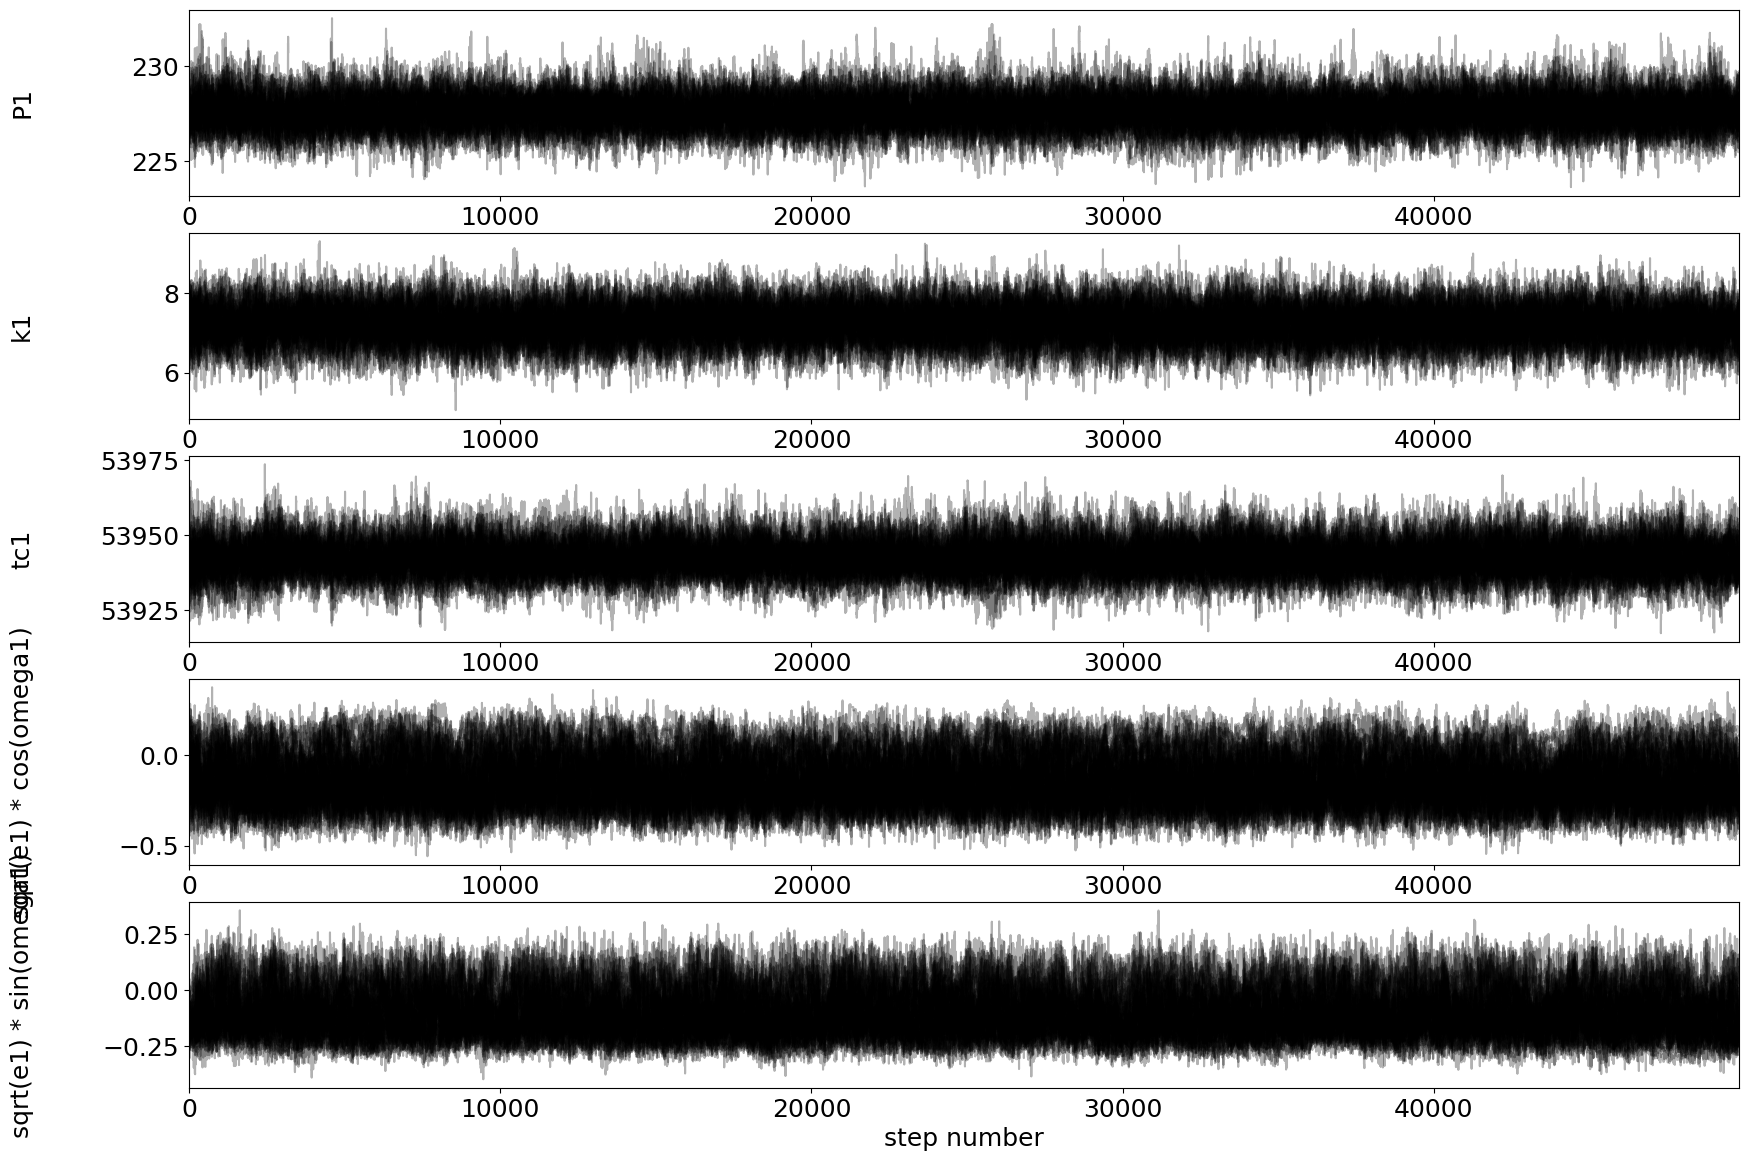

In [10]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels1 = ['P1', 'k1', 'tc1', 'sqrt(e1) * cos(omega1)', 'sqrt(e1) * sin(omega1)']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

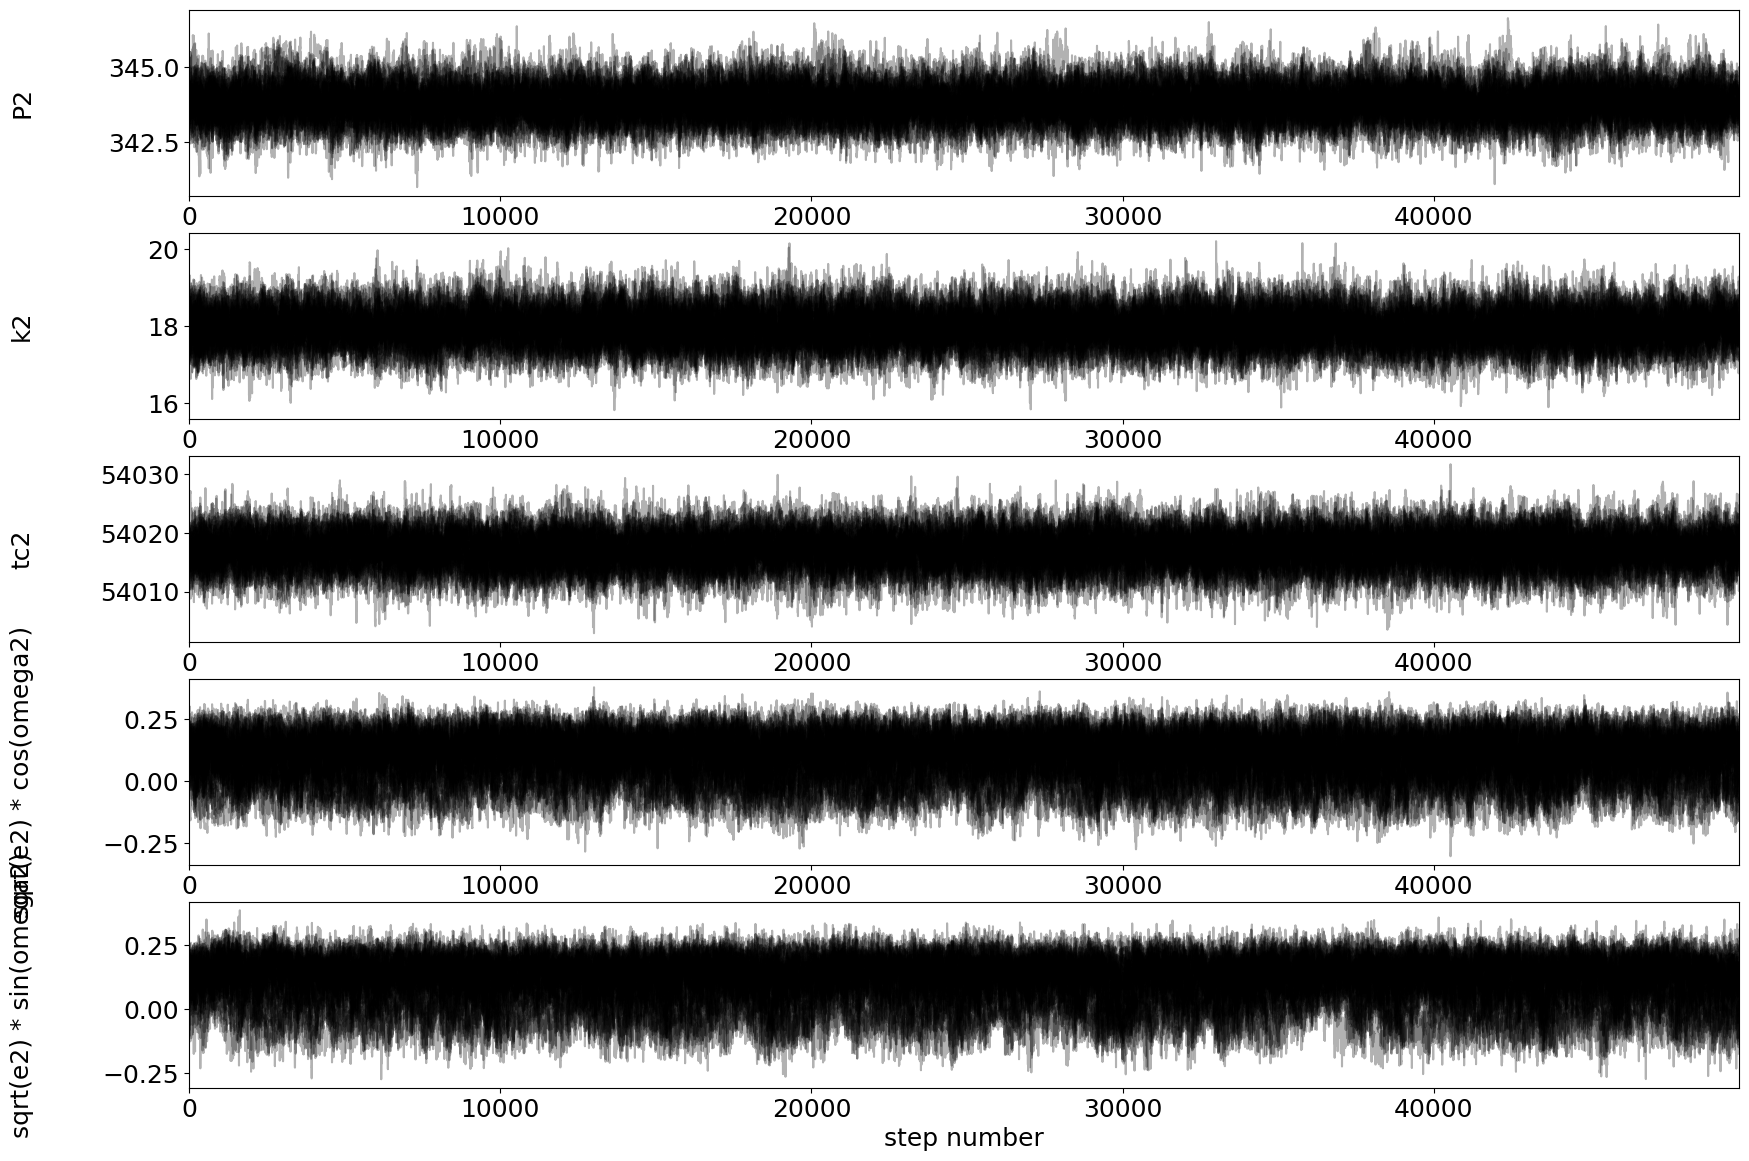

In [11]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels2 = ['P2', 'k2', 'tc2', 'sqrt(e2) * cos(omega2)', 'sqrt(e2) * sin(omega2)']

for i in range(5, 10):
    ax = axes[i - 5]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels2[i - 5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

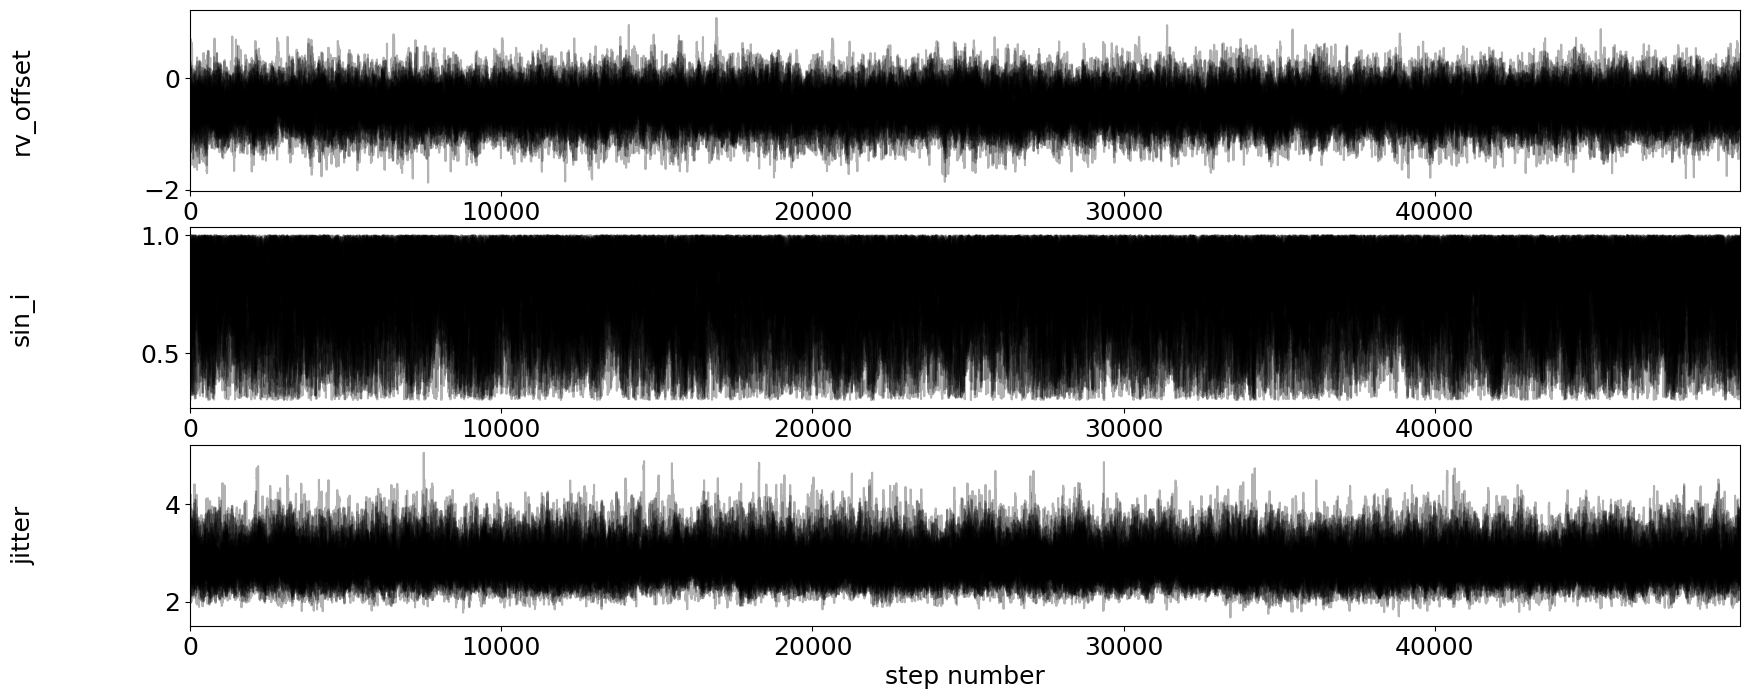

In [12]:
_, axes = pl.subplots(3, figsize=(20, 8))
labels3 = ['rv_offset', 'sin_i', 'jitter']
for i in range(10, 13):
    ax=axes[i - 10]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels3[i - 10])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");
        
# pl.figure(figsize = (20, 4))
# pl.plot(samples[:, :, 10], 'k', alpha = 0.3)
# pl.xlim(0, len(samples))
# pl.xlabel('step number'), pl.ylabel('rv_offset')

Computing posterior distribution of orbital elements:

In [13]:
e1 = samples[:, :, 3] ** 2 + samples[:, :, 4] ** 2  # computing eccentricity
e2 = samples[:, :, 8] ** 2 + samples[:, :, 9] ** 2  # computing eccentricity
p1 = samples[:, :, 0]
k1 = samples[:, :, 1]
p2 = samples[:, :, 5]
k2 = samples[:, :, 6]
tc1 = samples[:, :, 2]
tc2 = samples[:, :, 7]
omega1 = np.arctan2(samples[:, :, 3], samples[:, :, 4])  # omega is argument of periapsis
omega2 = np.arctan2(samples[:, :, 8], samples[:, :, 9])

jitter = samples[:, :, -1]
sin_i = samples[:, :, -2] # sin_i
rv_offset = samples[:, :, -3]  # rv_offset

 # print(k1.shape, p1.shape, e1.shape)

m1 = semiamp_to_mass(k1/(AUDAY_MS), STAR_MASS, p1, e1, inclination = np.arcsin(sin_i))
m2 = semiamp_to_mass(k2/(AUDAY_MS), STAR_MASS, p2, e2, inclination = np.arcsin(sin_i))
# print(m1.shape, e1.shape, m2.shape, e1.shape)

In [14]:
p1_best, k1_best, tc1_best, sq_e1cosomega1_best, sq_e1sinomega1_best, p2_best, k2_best, tc2_best, sq_e2cosomega2_best, sq_e2sinomega2_best, rv_offset_best, sini_best, jitter_best = best
e1_best = sq_e1cosomega1_best ** 2 + sq_e1sinomega1_best ** 2
e2_best = sq_e2cosomega2_best ** 2 + sq_e2sinomega2_best ** 2
omega1_best = np.arctan2(sq_e1cosomega1_best, sq_e1sinomega1_best)
omega2_best = np.arctan2(sq_e2cosomega2_best, sq_e2sinomega2_best)

m1_best = semiamp_to_mass(k1_best/AUDAY_MS, STAR_MASS, p1_best, e1_best, inclination = np.arcsin(sini_best))
m2_best = semiamp_to_mass(k2_best/AUDAY_MS, STAR_MASS, p2_best, e2_best, inclination = np.arcsin(sini_best))

pd.DataFrame(data = [m1_best, p1_best, e1_best, tc1_best, omega1_best, 
                     m2_best, p2_best, e2_best, tc2_best, omega2_best, rv_offset_best, sini_best, jitter_best], 
             index = ['m1', 'p1', 'e1', 'tc1', 'omega1', 
                              'm2', 'p2', 'e2', 'tc2', 'omega2', 
                              'rv_offset', 'sin_i', 'jitter'], columns=['best'])

,best
m1,0.198863
p1,227.442446
e1,0.036848
tc1,53939.453768
omega1,-2.929977
m2,0.565876
p2,343.961865
e2,0.024003
tc2,54017.919914
omega2,0.590253


In [15]:
pd.DataFrame(data=[np.quantile(m1.reshape(-1), [0.05, 0.5, 0.95]), 
                   np.quantile(p1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(m2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(p2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(sin_i.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(jitter.reshape(-1), [0.01, 0.5, 0.95])
                  ], index = ['m1', 'p1', 'e1', 'tc1', 'omega1', 
                              'm2', 'p2', 'e2', 'tc2', 'omega2', 
                              'rv_offset', 'sin_i', 'jitter'], 
             columns=['5%', '50%', '95%'])

,5%,50%,95%
m1,0.196651,0.244594,0.409453
p1,226.348398,227.594475,228.895691
e1,0.006126,0.052473,0.122339
tc1,53933.736765,53941.642042,53950.518788
omega1,-2.948514,-1.971928,2.900638
m2,0.573034,0.695904,1.169430
p2,342.968539,343.798937,344.671630
e2,0.004810,0.036839,0.071930
tc2,54012.633398,54017.344532,54021.672083
omega2,-0.800202,0.668928,1.907053


Start sims with $m_1 = 1\times 10^{-6}$ star masses and take $m_2/m_1$ to be based on the posterior median (median of m2/m1, not (median of m2)/(median of m1)):

In [16]:
m2m1_median = np.median(m2.reshape(-1)/m1.reshape(-1))  # m2/m1 based on the posterior median
m1_init = 1e-6  # initial mass of m1

Create array of $K = \tau_a/\tau_e$ values to iterate over:

In [17]:
nsims = 100
Ks = np.geomspace(1, 1000, nsims)

Initialize simulation with specific $K$ value, migrate and capture in resonance for each $K$ value, turn off $\tau_a$ and $\tau_e$, and then grow masses until they become unstable:

In [18]:
def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    """
    helper function to get tau_a values for the maximum stable mass computation

    returns (tau_a_outer, tau_a_inner) as a tuple
    """
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

# NOTE: could change tau_e_factor to be a little larger, think that might cause the eccentricities to approach
# the upper asymptote a bit more quickly...
def get_maximum_stable_masses(params, period_ratio=3/2, t_end=3e4, tau_e_factor=3):
    """
    Gets the maximum stable masses for a simulation with two planets, assuming that planets are coplanar and in MMR with
    period ratio period_ratio

    params: tuple of (masses, K, filename):
    masses is an array of planet masses with [inner_planet_mass, outer_planet_mass]
    K is the tau_a/tau_e ratio for the simulation (ratio of semi-major axis damping to eccentricity damping timescale)
    filename is the filename to save the simulation archive to

    Returns (max_mass_inner, max_mass_outer) as a tuple, in units of Jupiter masses
    """
    masses, K, filename = params
    
    # initialize sim
    sim = get_simple_sim(masses)

    inner = sim.particles[1]  # inner and outer planets
    outer = sim.particles[2]
    # add tau_a and tau_e, eccentricity and migration forces
    rebx = reboundx.Extras(sim)
    
    force_forces = rebx.load_force('modify_orbits_forces')
    operator_direct = rebx.load_operator('modify_orbits_direct')
    rebx.add_force(force_forces)
    rebx.add_operator(operator_direct)
    # set the tau_e parameters, both planets will share a common tau_e
    # these will be constant for any value of K, only based on the tau_e_factor 
    # (the absolute amount of damping, can be changed for quicker convergence)
    inner.params['tau_e'] = -t_end/tau_e_factor 
    outer.params['tau_e'] = -t_end/tau_e_factor
    # common tau_e value for the planets used in the K = tau_a/tau_e parameterization
    tau_e = 1/(1/inner.params['tau_e'] + 1/outer.params['tau_e'])

    # now set tau_a values for inner and outer planets based on the tau_e values:
    outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m, period_ratio = period_ratio)

    # now integrate to t_end to get to the equilibrium eccentricity point
    sim.integrate(t_end)

    # now turn off tau_a and tau_e, and grow masses until they become unstable
    rebx.remove_force(force_forces)
    rebx.remove_operator(operator_direct)
    
    # finally grow the masses until they become unstable
    operator_mass = rebx.load_operator('modify_mass')
    rebx.add_operator(operator_mass)
    inner.params['tau_mass'] = 1e5  # use tau_mass = 1e5 for both planets, grow at the same rate
    outer.params['tau_mass'] = 1e5  # NOTE: larger tau_mass results in lower max masses, could be due to slower growth rate?
    # define 5 times the inner planet's hill distance as a close encounter (system becomes unstable)
    sim.exit_min_distance = 5 * inner.rhill

    # integrate:
    try:
        sim.integrate(
            1e8)  # doesn't matter what this number is since eventually there will be a close encounter 
        # as long as it's large enough so the encounter happens eventually
    except rb.Encounter as error:
        pass

    # sim
    sim.save(filename)  # save in simulation file individually

    # max masses
    max_m1 = inner.m * STAR_MASS
    max_m2 = outer.m * STAR_MASS
    # since masses are jupiter masses, multiply by conversion factor to get the max masses in jupiter masses

    # return the max masses in the order (inner, outer)
    return max_m1, max_m2

Now set up the multiprocessing parameters:

In [19]:
# use starting planet masses m1=1e-6 and m2 decided by the posterior median m2/m1 value
planet_masses = [m1_init, m1_init * m2m1_median]
foldername = 'hd_max_mass_february_2024'

par_list = []
for i, K in enumerate(Ks):
    # simulationarchive:
    filename_mass = f'{foldername}/max_mass_archive_local_{i}.bin'
    par_list.append((planet_masses, K, filename_mass))

**Run following two code cells only if need to generate simulations**

And perform the multiprocessing:

In [ ]:
pool = InterruptiblePool()
max_mass_results = pool.map(get_maximum_stable_masses, par_list)  # compute the maximum m1s and m2s
# 50 simulations takes a long time on my home machine but the ones between like ~3 and 9 take up most of the time because of huge maximum masses

Get maximum m1s and m2s:

In [ ]:
# get the maximum m1s and m2s
max_m1s = [max_masses[0] for max_masses in max_mass_results]
max_m2s = [max_masses[1] for max_masses in max_mass_results]

**Run following cell to get the maximum mass results from the simulationarchives if already exist**

In [26]:
mass_sims_location = 'hd_max_mass_february_2024'  # folder that the ecc sims are in
max_m1s, max_m2s = np.zeros(nsims), np.zeros(nsims)

for i in range(0, nsims):
    if not os.path.isfile(f'{mass_sims_location}/max_mass_archive_local_{i}.bin'):  # if simulationarchive doesn't exist just skip it
        continue
    mass_sim = rb.Simulation(f'{mass_sims_location}/max_mass_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = mass_sim.particles[1]
    outer = mass_sim.particles[2]
    
    max_m1s[i] = inner.m * STAR_MASS  # inner and outer planet masses
    max_m2s[i] = outer.m * STAR_MASS

Plot maximum planet mass as a function of $K$:

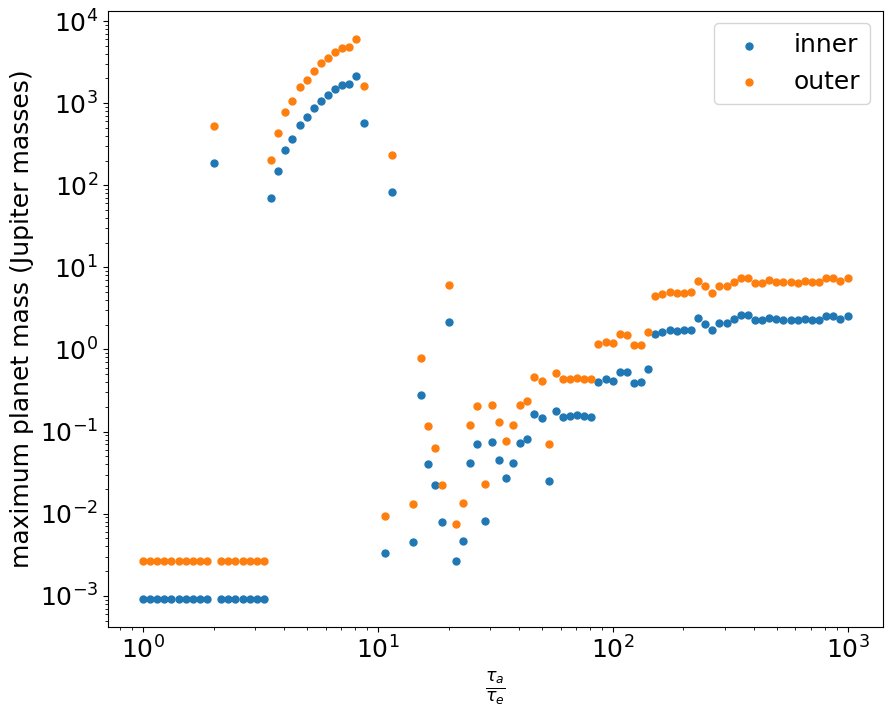

In [29]:
pl.figure(figsize = (10, 8))
pl.rc('font', size=18)
pl.scatter(Ks, max_m1s, label = 'inner')
pl.scatter(Ks, max_m2s, label = 'outer')
pl.xscale('log'), pl.yscale('log')
pl.xlabel(r'$\frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
# pl.ylim(-0.1, 7)
pl.legend(loc = 'upper right')

### Convert posteriors to $K$ values:

Convert posteriors to $K = \tau_a/\tau_e$ values using the semi-analytic Hamiltonian model with dissipative forces derived in summer 2022:

### Get full MCMC chains/posteriors for different $A$-penalties:

Get the full MCMC chains and posteriors for libration penalty $A = [0.1,\dots,1]$ to see how they compare with the $A = 0.3$ we used first, using new lower bounds on $\sin(i)$ determined from the maximum planet mass calculations

- Get posteriors for A-penalty = [0.1,…,1]
 - Posteriors —> tau_a / tau_e

## testing:

In [98]:
test_sim = get_sim_from_params(fit_params, integrator='ias15', time_base=obs_time_base)
test_sim.particles[1].m/STAR_MASS, test_sim.particles[2].m/STAR_MASS

(0.00021814016556630797, 0.0006133338873173085)

In [99]:
masses_test

[1e-06, 3.504756572101125e-07]

In [100]:
masses_test = [m1_init, m1_init * m1m2_median]
K_test = 100
filename_test = f'test_archive_local_{K_test}.bin'

params_test = ([test_sim.particles[1].m/STAR_MASS, test_sim.particles[2].m/STAR_MASS], K_test, filename_test)

get_maximum_stable_mass(params_test)



(1.7499396506440776, 4.920218547166356)

- Mass upper limit as function of tau_a/tau_e (e.g., geomspace(3,1000)):
    - Start sims with small masses (e.g., m~1e-6), taking m1/m2 based on posterior median
    - Migrate and capture in resonance for fixed tau_a/tau_e
    - turn off tau_a and tau_e
    - Use reboundx grow masses and determine maximum stable masses